In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import numpy as np
train = pd.read_csv("Train.csv")
test = pd.read_csv("Test.csv")


In [193]:
train

,id_code,diagnosis
0,Train_1,2
1,Train_2,2
2,Train_3,4
3,Train_4,2
4,Train_5,3
...,...,...
4204,Train_4205,2
4205,Train_4206,2
4206,Train_4207,2
4207,Train_4208,0


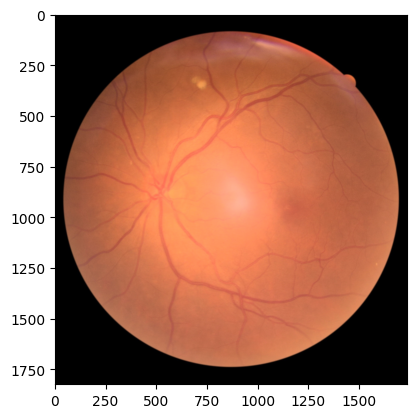

In [84]:
img = mpimg.imread('Train\\Train\\0\\train_6.jpg')
plt.imshow(img)

In [3]:
class CustomMatrixMetric(tf.keras.metrics.Metric):
    def __init__(self, name='custom_matrix_metric', **kwargs):
        super(CustomMatrixMetric, self).__init__(name=name, **kwargs)
        self.total = self.add_weight(name='total', initializer='zeros')
        self.count = self.add_weight(name='count', initializer='zeros')
    
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred_classes = tf.argmax(y_pred, axis=-1)
        y_true_classes = tf.argmax(y_true, axis=-1)
        distant = tf.cast(tf.abs(y_pred_classes - y_true_classes), dtype=tf.float32)
        matrix = 1 - tf.math.pow(distant / 4, 2)
        value = tf.reduce_sum(matrix)
        count = tf.cast(tf.size(y_true_classes), dtype=tf.float32)
        if sample_weight is not None:
            sample_weight = tf.cast(sample_weight, dtype=tf.float32)
            sample_weight = tf.broadcast_to(sample_weight, shape=y_true_classes.shape)
            count = tf.reduce_sum(sample_weight)
            value = tf.reduce_sum(matrix * sample_weight)
        self.total.assign_add(value)
        self.count.assign_add(count)
    
    def result(self):
        return self.total / self.count
    
    def reset_state(self):
        self.total.assign(0.0)
        self.count.assign(0.0)


In [105]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Dense, Flatten

#model1

# Load pre-trained ResNet50 model
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in resnet_model.layers:
    layer.trainable = False

# Add new layers to the ResNet50 model
x1 = resnet_model.output
x1 = Flatten()(x1)
x1 = Dense(50, activation='relu')(x1)
predictions1 = Dense(2, activation='softmax')(x1)

model1 = tf.keras.Model(inputs=resnet_model.input, outputs=predictions1)
model1.summary()

Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [106]:
#model1
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define a preprocessing function to apply to images
def custom_preprocessing(image):
    # padding -> down-sampling -> 
    
    # Apply per-image standardization
    height,width = image.shape[0:2]
    n=0;m=0
    if height > width:
        m = abs(height-width)//2
    else:
        n= abs(height-width)//2

    paddings = tf.constant([[n, n], [m, m],[0,0]]) 
    image = tf.pad(image, paddings, mode='CONSTANT')
    new_size = (224, 224)
    image = tf.image.resize(image, new_size, method='bilinear')
    image = tf.image.per_image_standardization(image)
    return image


# Define data generators for training and validation sets
train_datagen = ImageDataGenerator(
    preprocessing_function=custom_preprocessing,
    validation_split=0.2,
    #rescale=1./255,           # rescale pixel values to [0,1]
    rotation_range=20,        # random rotation up to 20 degrees
    width_shift_range=0.1,    # random horizontal shift up to 10%
    height_shift_range=0.1,   # random vertical shift up to 10%
   #3 shear_range=0.1,          # random shearing up to 10%
    zoom_range=0.1,           # random zoom up to 10%
    horizontal_flip=True,     # random horizontal flip
    fill_mode='nearest'       # fill any missing pixels with nearest neighbor
)

#val_datagen = ImageDataGenerator(preprocessing_function=custom_preprocessing)  # split form train data (validation_split=0.2)

# Define paths to the training and validation sets
train_dir = 'Train/Train/ING/'

# Set the batch size and image dimensions
batch_size = 10
img_height = 224
img_width = 224

# Create data generators for training and validation sets
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True,
)

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False,
)

# Compile and train the model using the data generators
model1.compile(optimizer= tf.keras.optimizers.Adam() , loss='categorical_crossentropy', metrics=['accuracy'])
history = model1.fit(
    train_generator,
    epochs=100,
    validation_data=val_generator
)

Found 3032 images belonging to 2 classes.
Found 757 images belonging to 2 classes.
Epoch 1/100
304/304 [==============================] - 113s 365ms/step - loss: 0.9024 - accuracy: 0.7015 - val_loss: 0.7225 - val_accuracy: 0.6948
Epoch 2/100
304/304 [==============================] - 105s 345ms/step - loss: 0.5664 - accuracy: 0.7543 - val_loss: 0.4669 - val_accuracy: 0.7820
Epoch 3/100
304/304 [==============================] - 106s 348ms/step - loss: 0.4783 - accuracy: 0.7803 - val_loss: 0.4933 - val_accuracy: 0.7477
Epoch 4/100
304/304 [==============================] - 105s 344ms/step - loss: 0.4680 - accuracy: 0.7721 - val_loss: 0.4805 - val_accuracy: 0.7517
Epoch 5/100
304/304 [==============================] - 106s 350ms/step - loss: 0.4318 - accuracy: 0.8008 - val_loss: 0.4515 - val_accuracy: 0.7662
Epoch 6/100
304/304 [==============================] - 103s 341ms/step - loss: 0.4284 - accuracy: 0.7949 - val_loss: 0.4674 - val_accuracy: 0.7715
Epoch 7/100
304/304 [==============

Epoch 56/100
304/304 [==============================] - 100s 330ms/step - loss: 0.3238 - accuracy: 0.8668 - val_loss: 0.3769 - val_accuracy: 0.8230
Epoch 57/100
304/304 [==============================] - 101s 332ms/step - loss: 0.3166 - accuracy: 0.8644 - val_loss: 0.3609 - val_accuracy: 0.8322
Epoch 58/100
304/304 [==============================] - 101s 331ms/step - loss: 0.3205 - accuracy: 0.8631 - val_loss: 0.6206 - val_accuracy: 0.7398
Epoch 59/100
304/304 [==============================] - 102s 335ms/step - loss: 0.3155 - accuracy: 0.8635 - val_loss: 0.4428 - val_accuracy: 0.7952
Epoch 60/100
304/304 [==============================] - 100s 330ms/step - loss: 0.3310 - accuracy: 0.8559 - val_loss: 0.3897 - val_accuracy: 0.8256
Epoch 61/100
304/304 [==============================] - 101s 333ms/step - loss: 0.3403 - accuracy: 0.8486 - val_loss: 0.3521 - val_accuracy: 0.8507
Epoch 62/100
304/304 [==============================] - 100s 330ms/step - loss: 0.3206 - accuracy: 0.8611 - val_

KeyboardInterrupt: 

In [ ]:
#Model2 
# Add new layers to the ResNet50 model
x2 = resnet_model.output
x2 = Flatten()(x2)
x2 = Dense(100, activation='relu')(x2)
predictions2 = Dense(2, activation='softmax')(x2)

model2 = tf.keras.Model(inputs=resnet_model.input, outputs=predictions2)

In [ ]:
#model2 12//34
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define a preprocessing function to apply to images
def custom_preprocessing(image):
    # padding -> down-sampling -> 
    
    # Apply per-image standardization
    height,width = image.shape[0:2]
    n=0;m=0
    if height > width:
        m = abs(height-width)//2
    else:
        n= abs(height-width)//2

    paddings = tf.constant([[n, n], [m, m],[0,0]]) 
    image = tf.pad(image, paddings, mode='CONSTANT')
    new_size = (224, 224)
    image = tf.image.resize(image, new_size, method='bilinear')
    image = tf.image.per_image_standardization(image)
    return image


# Define data generators for training and validation sets
train_datagen = ImageDataGenerator(
    preprocessing_function=custom_preprocessing,
    validation_split=0.2,
    #rescale=1./255,           # rescale pixel values to [0,1]
    rotation_range=20,        # random rotation up to 20 degrees
    width_shift_range=0.1,    # random horizontal shift up to 10%
    height_shift_range=0.1,   # random vertical shift up to 10%
   #3 shear_range=0.1,          # random shearing up to 10%
    zoom_range=0.1,           # random zoom up to 10%
    horizontal_flip=True,     # random horizontal flip
    fill_mode='nearest'       # fill any missing pixels with nearest neighbor
)

#val_datagen = ImageDataGenerator(preprocessing_function=custom_preprocessing)  # split form train data (validation_split=0.2)

# Define paths to the training and validation sets
train_dir = 'Train/Train/12n34'

# Set the batch size and image dimensions
batch_size = 10
img_height = 224
img_width = 224

# Create data generators for training and validation sets
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

# Compile and train the model using the data generators
model2.compile(optimizer= tf.keras.optimizers.Adam() , loss='categorical_crossentropy', metrics=['accuracy'])
history = model2.fit(
    train_generator,
    epochs=100,
    validation_data=val_generator,
    class_weight={0: 1, 1: 2, }
)

In [ ]:
#Model3
# Add new layers to the ResNet50 model
x3 = resnet_model.output
x3 = Flatten()(x3)
x3 = Dense(100, activation='relu')(x3)
predictions3 = Dense(2, activation='softmax')(x3)

model3 = tf.keras.Model(inputs=resnet_model.input, outputs=predictions3)

In [ ]:
#model3 1//2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define a preprocessing function to apply to images
def custom_preprocessing(image):
    # padding -> down-sampling -> 
    
    # Apply per-image standardization
    height,width = image.shape[0:2]
    n=0;m=0
    if height > width:
        m = abs(height-width)//2
    else:
        n= abs(height-width)//2

    paddings = tf.constant([[n, n], [m, m],[0,0]]) 
    image = tf.pad(image, paddings, mode='CONSTANT')
    new_size = (224, 224)
    image = tf.image.resize(image, new_size, method='bilinear')
    image = tf.image.per_image_standardization(image)
    return image


# Define data generators for training and validation sets
train_datagen = ImageDataGenerator(
    preprocessing_function=custom_preprocessing,
    validation_split=0.2,
    #rescale=1./255,           # rescale pixel values to [0,1]
    rotation_range=20,        # random rotation up to 20 degrees
    width_shift_range=0.1,    # random horizontal shift up to 10%
    height_shift_range=0.1,   # random vertical shift up to 10%
   #3 shear_range=0.1,          # random shearing up to 10%
    zoom_range=0.1,           # random zoom up to 10%
    horizontal_flip=True,     # random horizontal flip
    fill_mode='nearest'       # fill any missing pixels with nearest neighbor
)

#val_datagen = ImageDataGenerator(preprocessing_function=custom_preprocessing)  # split form train data (validation_split=0.2)

# Define paths to the training and validation sets
train_dir = 'Train/Train/12/'

# Set the batch size and image dimensions
batch_size = 10
img_height = 224
img_width = 224

# Create data generators for training and validation sets
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

# Compile and train the model using the data generators
model3.compile(optimizer= tf.keras.optimizers.Adam() , loss='categorical_crossentropy', metrics=['accuracy'])
history = model3.fit(
    train_generator,
    epochs=100,
    validation_data=val_generator,
    class_weight={0: 2.5, 1: 1, }
)

In [ ]:
#Model4
# Add new layers to the ResNet50 model
x4 = resnet_model.output
x4 = Flatten()(x4)
x4 = Dense(100, activation='relu')(x4)
predictions4 = Dense(2, activation='softmax')(x4)

model4 = tf.keras.Model(inputs=resnet_model.input, outputs=predictions4)
model4.summary()

In [ ]:
#model1 3//4
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define a preprocessing function to apply to images
def custom_preprocessing(image):
    # padding -> down-sampling -> 
    
    # Apply per-image standardization
    height,width = image.shape[0:2]
    n=0;m=0
    if height > width:
        m = abs(height-width)//2
    else:
        n= abs(height-width)//2

    paddings = tf.constant([[n, n], [m, m],[0,0]]) 
    image = tf.pad(image, paddings, mode='CONSTANT')
    new_size = (224, 224)
    image = tf.image.resize(image, new_size, method='bilinear')
    image = tf.image.per_image_standardization(image)
    return image


# Define data generators for training and validation sets
train_datagen = ImageDataGenerator(
    preprocessing_function=custom_preprocessing,
    validation_split=0.2,
    #rescale=1./255,           # rescale pixel values to [0,1]
    rotation_range=20,        # random rotation up to 20 degrees
    width_shift_range=0.1,    # random horizontal shift up to 10%
    height_shift_range=0.1,   # random vertical shift up to 10%
   #3 shear_range=0.1,          # random shearing up to 10%
    zoom_range=0.1,           # random zoom up to 10%
    horizontal_flip=True,     # random horizontal flip
    fill_mode='nearest'       # fill any missing pixels with nearest neighbor
)

#val_datagen = ImageDataGenerator(preprocessing_function=custom_preprocessing)  # split form train data (validation_split=0.2)

# Define paths to the training and validation sets
train_dir = 'Train/Train/34/'

# Set the batch size and image dimensions
batch_size = 10
img_height = 224
img_width = 224

# Create data generators for training and validation sets
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

# Compile and train the model using the data generators
model4.compile(optimizer= tf.keras.optimizers.Adam() , loss='categorical_crossentropy', metrics=['accuracy'])
history = model4.fit(
    train_generator,
    epochs=100,
    validation_data=val_generator,
    class_weight={0: 1, 1: 1.5, }
)

In [13]:
# Get the mapping between class names and labels
class_mapping = train_generator.class_indices

# Reverse the mapping so that labels are keys and class names are values
class_mapping = {v: k for k, v in class_mapping.items()}

# Print the mapping
print(class_mapping)

{0: '12', 1: '34'}


In [34]:
from tensorflow.keras.preprocessing.image import img_to_array, load_img
correct=np.zeros(5)
miss=np.zeros(5)
for i in range(4209):
    path=('Train/TrainG/Train_')
    img = load_img(path+str(i+1)+'.jpg', target_size=(224, 224))
    y=Model0(img)
    if(y == train['diagnosis'][i]):
        correct[y]+=1
    else:
        miss[y]+=1
    print(i,y,train['diagnosis'][i])    

0 2 2
1 2 2
2 2 4
3 3 2
4 3 3
5 0 0
6 0 0
7 0 2
8 0 0
9 0 2
10 0 0
11 2 4
12 0 0
13 2 2
14 2 2
15 3 0
16 0 0
17 3 1
18 0 0
19 0 2
20 3 1
21 0 0
22 0 0
23 2 4
24 0 0
25 0 0
26 2 2
27 0 0
28 2 1
29 2 1
30 0 0
31 2 2
32 3 3
33 0 0
34 2 2
35 0 0
36 3 4
37 1 1
38 0 0
39 2 0
40 0 0
41 3 2
42 2 2
43 1 1
44 0 0
45 0 0
46 2 3
47 0 2
48 2 2
49 0 1
50 2 4
51 2 1
52 3 3
53 0 0
54 2 4
55 0 0
56 2 2
57 3 3
58 3 4
59 0 2
60 2 2
61 3 3
62 4 2
63 0 0
64 0 0
65 2 2
66 2 2
67 2 2
68 0 0
69 2 2
70 0 0
71 2 2
72 3 0
73 2 2
74 0 0
75 2 0
76 0 0
77 0 3
78 2 4
79 2 2
80 0 0
81 0 0
82 1 1
83 3 4
84 0 0
85 2 0
86 0 0
87 2 2
88 2 2
89 2 2
90 2 2
91 2 2
92 2 2
93 0 0
94 3 4
95 0 0
96 0 0
97 2 0
98 2 1
99 0 0
100 0 0
101 0 0
102 0 0
103 3 3
104 3 3
105 0 0
106 2 4
107 0 0
108 3 4
109 0 0
110 2 4
111 3 4
112 2 0
113 3 4
114 2 3
115 0 0
116 0 0
117 0 0
118 3 1
119 0 0
120 2 1
121 0 0
122 1 4
123 2 2
124 0 2
125 0 0
126 0 0
127 0 0
128 0 0
129 0 0
130 0 0
131 0 0
132 0 0
133 2 1
134 1 2
135 3 2
136 0 0
137 3 4
138 0 

1037 2 0
1038 3 4
1039 2 1
1040 0 0
1041 0 2
1042 2 2
1043 0 0
1044 2 3
1045 0 0
1046 0 0
1047 0 0
1048 3 0
1049 3 2
1050 0 0
1051 2 0
1052 0 0
1053 2 1
1054 0 0
1055 2 2
1056 0 3
1057 2 2
1058 3 1
1059 0 0
1060 0 0
1061 3 3
1062 2 3
1063 2 4
1064 0 0
1065 2 3
1066 3 1
1067 4 4
1068 2 1
1069 0 0
1070 0 0
1071 0 0
1072 2 1
1073 2 2
1074 0 0
1075 0 0
1076 0 0
1077 2 2
1078 2 2
1079 3 0
1080 3 3
1081 0 0
1082 2 2
1083 0 0
1084 2 2
1085 0 0
1086 0 0
1087 0 0
1088 2 2
1089 0 0
1090 0 0
1091 0 0
1092 2 3
1093 0 0
1094 2 2
1095 2 2
1096 0 0
1097 0 0
1098 2 4
1099 0 1
1100 3 2
1101 0 2
1102 0 0
1103 3 4
1104 2 2
1105 3 2
1106 0 0
1107 2 2
1108 0 0
1109 0 0
1110 0 0
1111 2 2
1112 0 0
1113 2 2
1114 0 0
1115 1 0
1116 0 2
1117 2 4
1118 3 1
1119 2 2
1120 0 2
1121 0 4
1122 4 2
1123 2 0
1124 2 2
1125 0 0
1126 3 0
1127 0 3
1128 0 0
1129 0 0
1130 1 1
1131 0 0
1132 3 2
1133 0 0
1134 2 1
1135 2 3
1136 3 2
1137 2 3
1138 0 0
1139 2 2
1140 2 3
1141 0 0
1142 0 0
1143 0 0
1144 2 1
1145 0 0
1146 2 2
1147 0 0
1

KeyboardInterrupt: 

In [35]:
test

,id_code,diagnosis
0,Test_1,NaN
1,Test_2,NaN
2,Test_3,NaN
3,Test_4,NaN
4,Test_5,NaN
...,...,...
1963,Test_1964,NaN
1964,Test_1965,NaN
1965,Test_1966,NaN
1966,Test_1967,NaN


In [61]:
Ypredict=pd.read_csv('sample.csv', index_col=None)
Ypredict

,id_code,diagnosis
0,Test_1,0
1,Test_2,0
2,Test_3,0
3,Test_4,0
4,Test_5,0
...,...,...
1963,Test_1964,0
1964,Test_1965,0
1965,Test_1966,0
1966,Test_1967,0


In [50]:
from tensorflow.keras.preprocessing.image import img_to_array, load_img
Y=np.zeros(1968)
for i in range(1968):
    path=('Test/Test/Test_')
    img = load_img(path+str(i+1)+'.jpg', target_size=(224, 224))
    y=Model0(img)
    Y[i]=np.int32(y)
    print(i)   

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967


In [72]:
Y=np.array(Y[:], dtype = np.int32)
Ypredict['diagnosis'] = Y.astype(np.int32)
Ypredict['diagnosis'].value_counts()

0    969
2    712
3    190
1     77
4     20
Name: diagnosis, dtype: int64

In [82]:
Y=np.array(Y, dtype=np.int32)

In [87]:
Y.dtype

dtype('int32')

In [89]:
A=pd.DataFrame()
A['id_code']=Ypredict['id_code'].copy()
A['diagnosis']= np.array(Y, dtype=np.int32)
A['diagnosis'] = A['diagnosis'].astype('int32')
A['diagnosis'].value_counts()

0    969
2    712
3    190
1     77
4     20
Name: diagnosis, dtype: int64

In [ ]:
Ypredict['diagnosis']=Y
Ypredict.to_csv('prediction3.csv'.index=False)
Ypredict['diagnosis'].value_counts()

In [32]:
def Model0(img):
    img = np.array(img)
    img = custom_preprocessing(img)
    y=np.argmax(model1.predict(img[None,:,:,:]))
    if (y != 0):
        y=np.argmax(model2.predict(img[None,:,:,:]))
        if (y ==0):
            predicted=np.argmax(model3.predict(img[None,:,:,:]))+1
        else:
            predicted=np.argmax(model4.predict(img[None,:,:,:]))+3
    else:
        predicted = 0
    return predicted

In [184]:
predict=pd.read_csv("prediction1.csv")

In [182]:
predict['diagnosis']=Y

In [186]:
predict.to_csv("prediction1-1.csv")